In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
pd.options.display.max_columns = None
import missingno as msno
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
#from imblearn.over_sampling import SMOTE

In [2]:
df=pd.read_csv("C:\\Users\\Eswar Reddy\\Downloads\\Banking-Domain-master\\bank-data.csv",sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.apply(lambda x:sum(x.isnull()),axis=0)

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [4]:
X_df=df.drop('y',axis=1)
y=df['y']
X_df.shape,y.shape

((41188, 20), (41188,))

In [5]:
y=pd.Series(np.where(y.values=='yes',1,0),y.index)

In [6]:
y.value_counts()

0    36548
1     4640
dtype: int64

In [7]:
# Label encode categorical variables.

label_encoder = LabelEncoder()
mappings = []

# Desired label orders for categorical columns.

educ_order = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri']

# using cat.codes for order, one hot for high cardinality and weak case of cardinality.

def ordered_labels(df, col, order):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.reorder_categories(order, ordered=True)
    df[col] = df[col].cat.codes.astype(int)

# Use dummy variables for occupation
X_df = pd.concat([X_df, pd.get_dummies(X_df['job'])],axis=1).drop('job',axis=1)

# Use ordered cat.codes for days, months, and education
ordered_labels(X_df, 'education', educ_order)
ordered_labels(X_df, 'month', month_order)
ordered_labels(X_df, 'day_of_week', day_order)

# Same label encoding for rest since low cardinality
for i, col in enumerate(X_df):
    if X_df[col].dtype == 'object':
        X_df[col] = label_encoder.fit_transform(np.array(X_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

X_df.head()

,age,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
0,56,1,2,0,0,0,1,2,0,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0
1,57,1,5,1,0,0,1,2,0,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0
2,37,1,5,0,2,0,1,2,0,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0
3,40,1,3,0,0,0,1,2,0,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0
4,56,1,5,0,0,2,1,2,0,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0


In [8]:
# Split feature and label sets to train and data sets.

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32950, 31), (8238, 31), (32950,), (8238,))

In [9]:
# Normalize using MinMaxScaler to constrain values to between 0 and 1.

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , RandomForestClassifier())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 15.5min finished


In [11]:
best_clf.best_estimator_.get_params()['classifier']

RandomForestClassifier(max_features=16, n_estimators=90)

In [12]:
print('Model accuracy is',best_clf.score(X_test, y_test))

Model accuracy is 0.9118718135469774


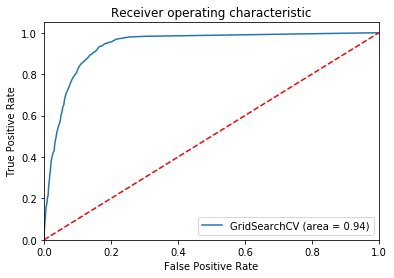

In [13]:
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [14]:
classes = best_clf.predict(X_test)
    
accuracy = metrics.accuracy_score(classes, y_test)
    
balanced_accuracy = metrics.balanced_accuracy_score(classes, y_test)

precision = metrics.precision_score(classes, y_test)
    
average_precision = metrics.average_precision_score(classes, y_test)
    
f1_score = metrics.f1_score(classes, y_test)
    
recall = metrics.recall_score(classes, y_test)

print (accuracy, balanced_accuracy, precision, average_precision, f1_score, recall, roc_auc)

0.9118718135469774 0.7864441804325021 0.5193965517241379 0.36253100800334753 0.5704142011834318 0.6325459317585301 0.9368746019859427


In [15]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7476
           1       0.52      0.63      0.57       762

    accuracy                           0.91      8238
   macro avg       0.74      0.79      0.76      8238
weighted avg       0.92      0.91      0.92      8238



In [17]:
# Rerunning above with resampled data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

best_clf = clf.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 36.2min finished


In [18]:
best_clf.best_estimator_.get_params()['classifier']

RandomForestClassifier(max_features=6, n_estimators=70)

In [19]:
print('Model accuracy is',best_clf.score(X_test, y_test))

Model accuracy is 0.9072590434571498


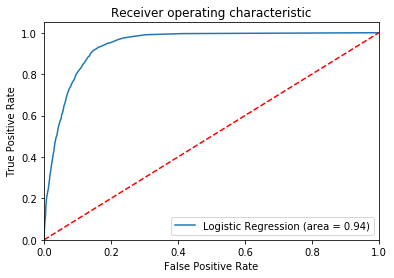

In [20]:
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()